# Organize ECG recordings with segmentation information
The data is downloaded from PhysioNet data base. One can find the data here https://www.physionet.org/content/qtdb/1.0.0/

This note book describes the process of how to prepare the data into segmentation format, so that one can use this data to conduct signal segmentation or sequence prediction exercise. 


In [2]:
# import necessary modules that we will use during this tutorial
import os, sys
import cardio.batchflow as bf   # the old 'cardio.dataset' has been renamed to this 'cardio.batchflow'
import numpy as np
import matplotlib.pyplot as plt
from cardio import EcgBatch
from cardio import EcgDataset


Before you execute the next section, you will have to download the data, put into the folder where the this python file is located. I saved my data in the folder "qt-database-1.0.0". 
The file in this folder may look like:
![data_folder](https://github.com/CodyDeepPlay/StudyExamples/blob/master/ECG_signals/data_folder.JPG)

Next, we will load this data using its index system. And print the index to have a look. The data will be saved in parameter "dtst". 

In [3]:
current_dir    = os.getcwd()  # get current working directory
SIGNALS_FOLDER = current_dir + "\\qt-database-1.0.0"
SIGNALS_MASK   = os.path.join(SIGNALS_FOLDER,  "*.hea")  # .hea, header file, describing signal file contents and format

# when data comes from a file system, it might be convenient to use 'FileIndex',
# it is coming from batchflow module.
index = bf.FilesIndex(path=SIGNALS_MASK,  # directory of the file location
                      no_ext=True,        # when filenames contain extensions which are not part of the id, then they maybe stripped with this option
                      sort=True)          # sort the order of your file index

# now ECG is indexed with its filename without extension, as it is defined by "no_ext" argument of FileIndex
# indices are stored in index.indices
dtst  = bf.Dataset(index, batch_class=EcgBatch)  # batch_class holds the data and contains processing functions. refer to documentation 'batch classes'
print(index.indices)    

['sel100' 'sel102' 'sel103' 'sel104' 'sel114' 'sel116' 'sel117' 'sel123'
 'sel14046' 'sel14157' 'sel14172' 'sel15814' 'sel16265' 'sel16272'
 'sel16273' 'sel16420' 'sel16483' 'sel16539' 'sel16773' 'sel16786'
 'sel16795' 'sel17152' 'sel17453' 'sel213' 'sel221' 'sel223' 'sel230'
 'sel231' 'sel232' 'sel233' 'sel30' 'sel301' 'sel302' 'sel306' 'sel307'
 'sel308' 'sel31' 'sel310' 'sel32' 'sel33' 'sel34' 'sel35' 'sel36' 'sel37'
 'sel38' 'sel39' 'sel40' 'sel41' 'sel42' 'sel43' 'sel44' 'sel45' 'sel46'
 'sel47' 'sel48' 'sel49' 'sel50' 'sel51' 'sel52' 'sel803' 'sel808'
 'sel811' 'sel820' 'sel821' 'sel840' 'sel847' 'sel853' 'sel871' 'sel872'
 'sel873' 'sel883' 'sel891' 'sele0104' 'sele0106' 'sele0107' 'sele0110'
 'sele0111' 'sele0112' 'sele0114' 'sele0116' 'sele0121' 'sele0122'
 'sele0124' 'sele0126' 'sele0129' 'sele0133' 'sele0136' 'sele0166'
 'sele0170' 'sele0203' 'sele0210' 'sele0211' 'sele0303' 'sele0405'
 'sele0406' 'sele0409' 'sele0411' 'sele0509' 'sele0603' 'sele0604'
 'sele0606' 'sele0607' 

Next, we will use batchflow's pipeline to help to read all the annotation associated with the ECG recordings. 

For pipeline, refer https://analysiscenter.github.io/batchflow/api/batchflow.pipeline.html

Below also we use some custom function to help to combine "anntype" and "annsamp" togeter, and generate a new annotation, which can be corresponding to the raw ECG recording. 

The functions below are borrowed from this notebook from cardio
https://github.com/analysiscenter/cardio/blob/master/cardio/models/hmm/hmmodel_training.ipynb

In [4]:
'''
Functions that will help to convert "anntype" and "annsamp" into annotation data
that can corresponding to the ECG raw signal recording.
'''    
def expand_annotation(annsamp_0, anntype_0, length):
    """
    Unravel annotation
    
    anntype_0 and annsamp_0 are with the same size.
    
    anntype_0:  contain the actual annotation with strings to indicate what each section of the signal is
        ['(', 'p', ')', '(', 'N'...]
    
    annsamp_0: contain the corresponding index of the annotation in anntype_0
        ([ 92, 106, 115, 129, 140 ...])
    
    """
    begin = -1
    end = -1
    s = 'none'
    states = {'N':0, 'st':1, 't':2, 'iso':3, 'p':4, 'pq':5}
    annot_expand = -1 * np.ones(length)

    for j, samp in enumerate(annsamp_0):
        
        # FOR A NEW ANNOTATION STARTS
        if anntype_0[j] == '(': # if the annotation starts with "(", that means a new annotation starts
            begin = samp        # the index that is stored in annsamp_0
            # Determine what is the label number for this coming new annotation string.
            if (end > 0) & (s != 'none'):
                              
                # the previous annotation is 'N', 'N' stands for normal, which is a QRS peak,
                # so the next section from [end:begin] should be 'st', which is after 'N'
                if s == 'N':
                    annot_expand[end:begin] = states['st']               
                               
                # the previous annotation is 't'
                # so the next section from [end:begin] should be 'iso', which is after 't'
                
                elif s == 't': # if current string is 't', 
                    annot_expand[end:begin] = states['iso']
                
                # previous annotation string is 'p', when coming to the if-statement here, the current 
                # string is '(', and the current index is assigned to 'begin'
                # previous end index for previous annotation is already stored in 'end'
                elif s == 'p':                              # since previous annotation string is 'p'
                    annot_expand[end:begin] = states['pq']  # so between last index 'end', to current index 'begin' is 'pq', which is the next section after 'p'
       
        # FOR THE CURRENT ANNOTATION ENDS
        elif anntype_0[j] == ')':    # if the annotation string is "(", that means the current annotation ends
            end = samp     # update the index that is stored in annsamp_0
            # update the last annotation label in this section with the currrent annotation string
            if (begin > 0) & (s != 'none'):
                annot_expand[begin:end] = states[s]
        
       
        # TAKE THE CURRENT ANNOTATION STRING, which is in between the annotation of '(' and ')'.
        else:
            s = anntype_0[j]   # take the current annotation string


    return annot_expand


def get_annsamples(batch):
    return [ann["annsamp"] for ann in batch.annotation]

def get_anntypes(batch):
    return [ann["anntype"] for ann in batch.annotation]


In [5]:
template_ppl_inits = (
    bf.Pipeline()  # refer pipeline API for more information
                   # https://analysiscenter.github.io/batchflow/api/batchflow.pipeline.html
      .init_variable("annsamps", init_on_each_run=list) # create a variable if not exists, before each run, initiate it a list, a method in Pipeline class
      .init_variable("anntypes", init_on_each_run=list)
      
      .load(       # this is coming from ECGBatch
            fmt='wfdb',        # (optional), source format
            components=["signal",      # from ECGBatch class, store ECG signals in numpy array
                        "annotation",  # from ECGBatch class, array of dicts with different types of annotations, e.g. array of R-peaks
                        "meta"],       # from ECGBatch class, array of dicts with metadata about ECG records, e.g. signal frequency
                        # (str or array like) components to load
            ann_ext='pu1')     # (str, optional), extension of the annotation file
            
   
      .update_variable(                       # update a value of a given variable lazily during pipeline executuion
                      "annsamps",             # name of the variable
                       bf.F(get_annsamples),  # a callable which take a batch (could be a batch class method or an arbitrary function)
                                              # here 'get_annsamples' was defined as a callable before
                       mode='e')              # mode 'e' extend a variable with new value, if a variable is a list  
      
      .update_variable("anntypes", 
                       bf.F(get_anntypes),    # a callable which take a batch (could be a batch class method or an arbitrary function)
                       mode='e')              # mode 'e' extend a variable with new value, if a variable is a list    
      
       # here the batch_size doesn't matter as we will not use the pipeline to read the data
       # but just use pipeline to read annotations. 
      .run(  # coming from pipeline
           batch_size=20,    # number of items in the batch
           shuffle=False,    # no conduct random shuffle
           drop_last=False,  # if True, drop the last batch if it contains fewer than batch_size items
           n_epochs=1,       # number of epoches required
           lazy=True) # execute all lazy actions for each batch in the dataset
      
)

ppl_inits = (dtst >> template_ppl_inits).run() # pass dataset to pipeline and run


Next, we will read the annotation, and data.
"anntype" is organized in batches, has 105 batches in total. For a given batch of data, it contains information like ['(','p',')','(','N',')'...]

Information in "annsamp" is corresponding to that within "anntype", for a given batch of data, it contains information like [ 92, 106, 115, 129, 140, 150...] , which are the indecies to show within raw recording from where to where, it contains certain notation. 

In [6]:

'''
dtst,      size of 105,105 batches of data
anntype,   size of 105, annotation type for ECG signal
            each batch contains the annotype for each batch of recording, different length
            anntype[0]: has size 10616, ['(','p',')','(','N',')'...]
            anntype[1]: has size 6939
            anntype[2]: has size 7289
            ...
annsamp,   size of 105, index for the annotation type in 'anntype'
            annsamp[0]: has size 10616, [ 92, 106, 115, 129, 140, 150...]
            annsamp[1]: has size 6939
            annsamp[2]: has size 7289
            ...
           
'''  
anntype = ppl_inits.get_variable("anntypes")  # return the variable value
annsamp = ppl_inits.get_variable("annsamps")
total_batches = len(anntype)

batch = dtst.next_batch(total_batches) # ask to load 20 batches of data
batch_with_data = batch.load(fmt='wfdb', components=["signal", "annotation", "meta"])

allsignals = batch_with_data.signal  # retrive all the bactches of data
allmetas   = batch_with_data.meta    # retrive all the meta information for the data


# get the time series length for each batch
lengths      = [my_signal.shape[1] for my_signal in allsignals]

all_expanded = []
# get the expanded annotation for all the batches of signals
for samp, types, length in zip(annsamp, anntype, lengths):
    all_expanded.append(expand_annotation(samp, types, length))    
        
which_batch = 0     
mybatch_length = len(allsignals)
print('Total number of batches is ' + str(mybatch_length))  
print('First batch of data has shape:') 
print(allsignals[which_batch].shape)        
      
fs = allmetas[which_batch]['fs']
print('Sampling rate is ' + str(fs))    

Total number of batches is 105
First batch of data has shape:
(2, 225000)
Sampling rate is 250


At this point, we have retrieved all the data in "allsignals", it contains 105 batches of data. Each batch is also a record. Each batch or record is 15 min long, 15*60*fs = 225000, fs=250 Hz.

Take the first batch as example, it contains two channels of recording, I guess they are just coming from different recording electordes/channels, representing the same ECG data. 

"allmetas" contain 105 batches of meta information for the recordings. i.e. allmetas[0]['fs'] can see the sampling frequency for the 1st batch of data. 

"all_expanded" contain 105 batches of annotation data, with each batch contains annotaion of all the data points per recording. For each batch, the length in expanded annotation should be the same as the corresponding batch of ECG raw recording data. The different section of the ECG signal is defined in "expand_annotation()", one can also see in the figure below and refer to the following webpage.

https://medium.com/data-analysis-center/annotating-ecg-signals-with-hidden-markov-model-56f8b9abd83a
![ecg demonstration](https://github.com/CodyDeepPlay/StudyExamples/blob/master/ECG_signals/ecg.JPG)

Next, we will plot the data and visualize the ECGs.

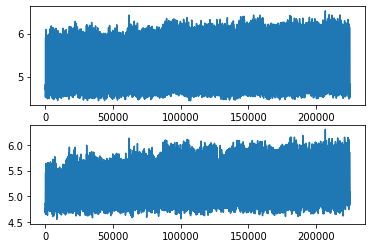

In [15]:
# Plot first record as example to see
first_record = allsignals[0]  # first batch/record of the data
plt.figure()
# plot the raw signal
plt.subplot(2,1,1)
plt.plot(first_record[0]) # first channel
plt.subplot(2,1,2)
plt.plot(first_record[1]) # first channel

Becaue the data is 15 min long, and samping rate is 250, so the data has 22500 data points for each recording. It is very long. So, when plotting, it doesn't make sense. 

Let's only select the first 500 data points for displaying.

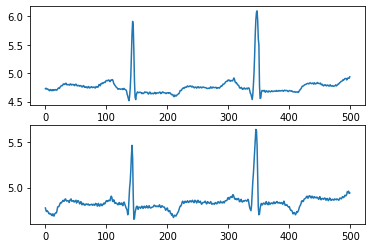

In [8]:
# Plot first record as example to see
first_record = allsignals[0]  # first batch/record of the data
plt.figure()
# plot the raw signal
plt.subplot(2,1,1)
plt.plot(first_record[0][0:500]) # first channel
plt.subplot(2,1,2)
plt.plot(first_record[1][0:500]) # first channel

Next, we will select example batches of data and plot the raw data with annotation. 

Text(0.5, 0, 'time (s)')

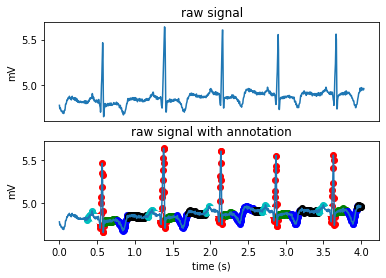

In [9]:
# select the first batch of the data to see what the annotaion and signal looks like
which_batch    = 0
display_length = 1000  # because each batch is a super long recording, here just display the first 1000 data points.

expanded      = all_expanded[which_batch]
my_signal     = allsignals[which_batch][1, 0:display_length]
my_annotation = expanded[0:display_length]

fs = allmetas[which_batch]['fs']                      # for this batch, get its sampling frequency
time_vector = np.arange( 0, display_length/fs, 1/fs)  # time vector for selected signal


plt.figure()
# plot the raw signal
plt.subplot(2,1,1)
plt.plot(time_vector, my_signal,)
plt.title('raw signal')
plt.xticks([]) # hide x axis
plt.ylabel('mV')

# plot the raw signal with different annotations for each section within the signal
plt.subplot(2,1,2)
plt.plot(time_vector, my_signal,)
plt.title('raw signal with annotation')
myN = np.where(my_annotation==0)[0]
plt.scatter(time_vector[myN], my_signal[myN], color='r', marker='o' )

myst = np.where(my_annotation==1)[0]
plt.scatter(time_vector[myst], my_signal[myst], color='g', marker='o')

myt = np.where(my_annotation==2)[0]
plt.scatter(time_vector[myt], my_signal[myt], color='b', marker='o')

myiso = np.where(my_annotation==3)[0]
plt.scatter(time_vector[myiso], my_signal[myiso], color='k', marker='o')

myp = np.where(my_annotation==4)[0]
plt.scatter(time_vector[myp], my_signal[myp], color='c', marker='o')

mypq = np.where(my_annotation==5)[0]
plt.scatter(time_vector[mypq], my_signal[mypq], color='w', marker='o')
plt.ylabel('mV')
plt.xlabel('time (s)')

Take a look at the last batch of the data

Text(0.5, 0, 'time (s)')

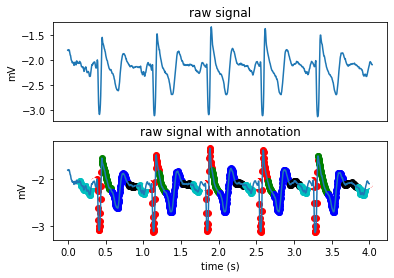

In [10]:
# select the last batch of data to take a look
which_batch    = 104
display_length = 1000

expanded      = all_expanded[which_batch]
my_signal     = allsignals[which_batch][1, 0:display_length]
my_annotation = expanded[0:display_length]

fs = allmetas[which_batch]['fs']                      # for this batch, get its sampling frequency
time_vector = np.arange( 0, display_length/fs, 1/fs)  # time vector for selected signal


plt.figure()
plt.subplot(2,1,1)
plt.plot(time_vector, my_signal,)
plt.title('raw signal')
plt.xticks([]) # hide x axis
plt.ylabel('mV')


plt.subplot(2,1,2)
plt.plot(time_vector, my_signal,)
plt.title('raw signal with annotation')
myN = np.where(my_annotation==0)[0]
plt.scatter(time_vector[myN], my_signal[myN], color='r', marker='o' )

myst = np.where(my_annotation==1)[0]
plt.scatter(time_vector[myst], my_signal[myst], color='g', marker='o')

myt = np.where(my_annotation==2)[0]
plt.scatter(time_vector[myt], my_signal[myt], color='b', marker='o')

myiso = np.where(my_annotation==3)[0]
plt.scatter(time_vector[myiso], my_signal[myiso], color='k', marker='o')

myp = np.where(my_annotation==4)[0]
plt.scatter(time_vector[myp], my_signal[myp], color='c', marker='o')

mypq = np.where(my_annotation==5)[0]
plt.scatter(time_vector[mypq], my_signal[mypq], color='w', marker='o')
plt.ylabel('mV')
plt.xlabel('time (s)')

As you can see above, the "allsignals" and "expanded" parameters has the raw signals and annotations that are corresponding to each other. 

Pay attention to the figures above, that at the begning there is no annotation in the figure. And if you look at the values in the annotion, these values are -1. This is because in expand_annotation() function defined before, for each long recording, the initialization is -1 for all annotations. For a lot of batches of data (long recordings), at the beginning there are often times no annotation available, so for some individual ECGs from the beginning of a batch (long recording), there is no annotation. 

In the following code, we will further clean out those annotations with -1, as we will not need them.

### Reorganize long recordings in each batch as individual ECGs.

Now we will try to truncate each ECG signal as individual signal, and put its annotation together with each ECG signal. 

First, we will iterate through each batch, 
Secondly, within each batch which is a very long recording, we will segment the ECG signal based on each QRS complex we see. 

The goal is to truncate each indivudla ECG signal, from P wave, QRS comlex to T wave. 

In [11]:
#%% Segment the data based on each ECG heart beat, from p-QRS-t.
'''
a regular ECG signal starts from P, PQ, QRS, ST, T.
Here, we use this physiological properties of the ECG signal, to segment an entire ECG signals, 
from a super long recording.
'''
single_ECG_list = []       # a big list to store all the ECG signals
single_annotation_list =[] # a big list to store all the annotations for each individual ECG signals


for which_batch in range(len(allsignals)):

    # iterate through each batch to the get raw signals and annotations.
    anntype_batch  = anntype[which_batch]  # this returns a list, with each list has a string, i.e.['(', 'p', ')', '(', 'N', ')'...]
    annsamp_batch  = annsamp[which_batch]  # this returns a list, with each list has index corresponds to anntype
    expanded_batch = all_expanded[which_batch]
    signal_batch   = allsignals[which_batch]
    
    P_locs = np.where(np.asarray(anntype_batch) == 'p')[0]
    T_locs = np.where(np.asarray(anntype_batch) == 't')[0]
    QRS_locs = np.where(np.asarray(anntype_batch) == 'N')[0]
    
    
    for n in range(len(QRS_locs)):   
    
        # in anntype for a batch, a QRS is annotated with  '(', 'N', ')'..., 
        QRS_start = annsamp[which_batch][QRS_locs[n]-1]  # here extract the index for QRS start "("
        QRS_end   = annsamp[which_batch][QRS_locs[n]+1]  # here extract the index for QRS end   ")"
        
        display_start  = QRS_start-50 # 50 data points before the start of QRS, which likely include P wave  
        display_end    = QRS_start+90 # 90 data points after the end of QRS, which likely to include T wave
        display_length = display_end - display_start
    
        my_single_ECG = signal_batch[0, display_start:display_end]  # a single ECG signal
        my_annotation = expanded_batch[display_start:display_end]   # the annotation related to this single ECG signal
    
        # get rid of the annotations where it contains -1,
        # this is the left over non-used annotation label from previous segmentation
        if -1 in set(my_annotation):
            pass
        else:
            single_ECG_list.append(my_single_ECG)
            single_annotation_list.append(my_annotation)

        
        
template = "Total number of batches of data is {}."
print(template.format( str(len(allsignals)) ) )
             
ECGS_len = len(single_ECG_list)
annot_len = len(single_annotation_list)  
template1 = "Total number of individual ECG recordings is {}. "
print(template1.format(str(ECGS_len)))
template2 = "Total number of individual annotations is {}. "
print(template2.format(str(annot_len)))

which_ind = 0   # take a look at an individual example
sig = len(single_ECG_list[0])
ann = len(single_annotation_list[0])

template3 = 'The length for {}th ECG example is {}, and its correponding annotation length is {}.'
print(template3.format(str(which_ind),
                     str(sig),
                     str(ann)))



Total number of batches of data is 105.
Total number of individual ECG recordings is 111167. 
Total number of individual annotations is 111167. 
The length for 0th ECG example is 140, and its correponding annotation length is 140.


As we cann see above that, there are 105 batches of data. After we put each invidual recordings together, there are 111288 different ECG recordings. For each recording, there should be 140 data points of raw signal, and 140 points of annotation correspond to this signal.

As we mentioned earlier, each reocrding has two channels, here we took the first channel, 
refer to the code above 
    "my_single_ECG = signal_batch[0, display_start:display_end]"
    
One can also use the second channel of data.

### plot an individual ECG signal, with its segmentation information
next, we will plot some example to show how the individual ECG signals and their corresponding annotation look like.

First, we take a look at the first example, "which_ECG_example = 0". 

(4.4443, 6.39975)

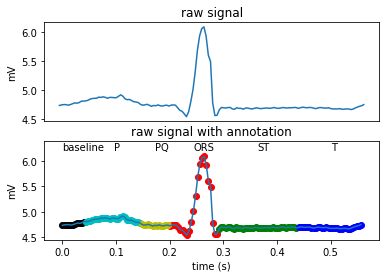

In [12]:
#%% plot an example to see the ECG signal with its annotation
which_ECG_example = 0
my_single_ECG = single_ECG_list[which_ECG_example]
my_annotation = single_annotation_list[which_ECG_example]

fs = allmetas[which_batch]['fs']                      # for this batch, get its sampling frequency
time_vector = np.arange( 0, display_length/fs, 1/fs)  # time vector for selected signal

plt.figure()
plt.subplot(2,1,1)
plt.plot(time_vector, my_single_ECG)
plt.title('raw signal')
plt.xticks([]) # hide x axis
plt.ylabel('mV')

ax=plt.subplot(2,1,2)
plt.plot(time_vector, my_single_ECG)
plt.title('raw signal with annotation')

max_amp = max(my_single_ECG)  # the max amplitude of this single ECG recording
min_amp = min(my_single_ECG)  # the max amplitude of this single ECG recording


# annotate each segment of the signal, based on the annotations we have
myN = np.where(my_annotation==0)[0]
if len(myN) !=0:
    plt.scatter(time_vector[myN], my_single_ECG[myN], color='r', marker='o' )
    mid_point = len(myN)//2
    ax.text(time_vector[myN[mid_point]], max_amp*1.02, 'ORS')
    
myst = np.where(my_annotation==1)[0]
if len(myst) !=0:
    plt.scatter(time_vector[myst], my_single_ECG[myst], color='g', marker='o')
    mid_point = len(myst)//2
    ax.text(time_vector[myst[mid_point]], max_amp*1.02, 'ST')

myt = np.where(my_annotation==2)[0]
if len(myt) !=0:
    plt.scatter(time_vector[myt], my_single_ECG[myt], color='b', marker='o')
    mid_point = len(myt)//2
    ax.text(time_vector[myt[mid_point]], max_amp*1.02, 'T')

myiso = np.where(my_annotation==3)[0]
if len(myiso) !=0:
    plt.scatter(time_vector[myiso], my_single_ECG[myiso], color='k', marker='o')
    mid_point = len(myiso)//2
    ax.text(time_vector[myiso[0]], max_amp*1.02, 'baseline')

myp = np.where(my_annotation==4)[0]
if len(myp) !=0:
    plt.scatter(time_vector[myp], my_single_ECG[myp], color='c', marker='o')
    mid_point = len(myp)//2
    ax.text(time_vector[myp[mid_point]], max_amp*1.02, 'P')

mypq = np.where(my_annotation==5)[0]
if len(myp) !=0:
    plt.scatter(time_vector[mypq], my_single_ECG[mypq], color='y', marker='o')
    mid_point = len(mypq)//2
    ax.text(time_vector[mypq[mid_point]], max_amp*1.02, 'PQ')
       
plt.ylabel('mV')
plt.xlabel('time (s)')
plt.ylim([min_amp-min_amp*0.02, max_amp*1.05])


Then, let's take a look at another example, which_ECG_example = 5986. Remember the total number of ECG reocrdings that are available is  111288. 

In [13]:
print(my_annotation)

[3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


(-1.4504, 2.66175)

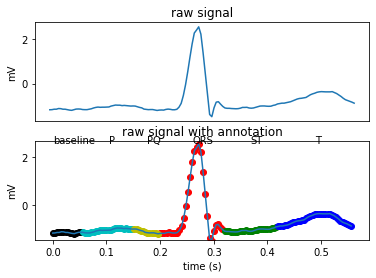

In [14]:
#%% plot an example to see the ECG signal with its annotation
which_ECG_example = 5986
my_single_ECG = single_ECG_list[which_ECG_example]
my_annotation = single_annotation_list[which_ECG_example]

fs = allmetas[which_batch]['fs']                      # for this batch, get its sampling frequency
time_vector = np.arange( 0, display_length/fs, 1/fs)  # time vector for selected signal

plt.figure()
plt.subplot(2,1,1)
plt.plot(time_vector, my_single_ECG)
plt.title('raw signal')
plt.xticks([]) # hide x axis
plt.ylabel('mV')

ax=plt.subplot(2,1,2)
plt.plot(time_vector, my_single_ECG)
plt.title('raw signal with annotation')

max_amp = max(my_single_ECG)  # the max amplitude of this single ECG recording
min_amp = min(my_single_ECG)  # the max amplitude of this single ECG recording


# annotate each segment of the signal, based on the annotations we have
myN = np.where(my_annotation==0)[0]
if len(myN) !=0:
    plt.scatter(time_vector[myN], my_single_ECG[myN], color='r', marker='o' )
    mid_point = len(myN)//2
    ax.text(time_vector[myN[mid_point]], max_amp*1.02, 'ORS')
    
myst = np.where(my_annotation==1)[0]
if len(myst) !=0:
    plt.scatter(time_vector[myst], my_single_ECG[myst], color='g', marker='o')
    mid_point = len(myst)//2
    ax.text(time_vector[myst[mid_point]], max_amp*1.02, 'ST')

myt = np.where(my_annotation==2)[0]
if len(myt) !=0:
    plt.scatter(time_vector[myt], my_single_ECG[myt], color='b', marker='o')
    mid_point = len(myt)//2
    ax.text(time_vector[myt[mid_point]], max_amp*1.02, 'T')

myiso = np.where(my_annotation==3)[0]
if len(myiso) !=0:
    plt.scatter(time_vector[myiso], my_single_ECG[myiso], color='k', marker='o')
    mid_point = len(myiso)//2
    ax.text(time_vector[myiso[0]], max_amp*1.02, 'baseline')

myp = np.where(my_annotation==4)[0]
if len(myp) !=0:
    plt.scatter(time_vector[myp], my_single_ECG[myp], color='c', marker='o')
    mid_point = len(myp)//2
    ax.text(time_vector[myp[mid_point]], max_amp*1.02, 'P')

mypq = np.where(my_annotation==5)[0]
if len(myp) !=0:
    plt.scatter(time_vector[mypq], my_single_ECG[mypq], color='y', marker='o')
    mid_point = len(mypq)//2
    ax.text(time_vector[mypq[mid_point]], max_amp*1.02, 'PQ')
       
plt.ylabel('mV')
plt.xlabel('time (s)')
plt.ylim([min_amp-min_amp*0.02, max_amp*1.05])

Now, you can use this data to conduct tasks like signal segmentation.
Enjoy!